#ALTEGRAD LAB 7


CHAUVIN Paul 

paulchauvin97@gmail.com

#Environment


In [3]:
!pip install graphein

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 185 kB 7.9 MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
     |████████████████████████████████| 878 kB 63.7 MB/s 
     |████████████████████████████████| 197 kB 72.2 MB/s 
     |████████████████████████████████| 72 kB 1.7 MB/s 
     |████████████████████████████████| 3.1 MB 65.4 MB/s 
     |████████████████████████████████| 9.4 MB 65.5 MB/s 
     |████████████████████████████████| 662 kB 68.8 MB/s 
     |████████████████████████████████| 237 kB 80.2 MB/s 
     |████████████████████████████████| 58 kB 6.6 MB/s 
     |████████████████████████████████| 47 kB 5.4 MB/s 
     |████████████████████████████████| 48 kB 7.1 MB/s 
     |████████████████████████████████| 144 kB 75.1 MB/s 
     |████████████████████████████████| 965 kB 57.7 MB/s 
     |████████████████████████

In [4]:
!pip install torch_geometric

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 564 kB 29.0 MB/s 
     |████████████████████████████████| 280 kB 72.2 MB/s 
  Created wheel for torch-geometric: filename=torch_geometric-2.2.0-py3-none-any.whl size=773302 sha256=e314ae4589a14ff7ff0bda04722dfb233cb28f1354410150ee41037d77c20b07
  Stored in directory: /root/.cache/pip/wheels/59/a3/20/198928106d3169865ae73afcbd3d3d1796cf6b429b55c65378
Successfully built torch-geometric
  Attempting uninstall: psutil
    Found existing installation: psutil 5.4.8
    Uninstalling psutil-5.4.8:
      Successfully uninstalled psutil-5.4.8


In [36]:
#importing the libraries
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch import nn
from torch.nn import functional as F
from torch import optim
import time
import scipy.sparse as sp
from sklearn.metrics import accuracy_score, mean_absolute_error
from sklearn.model_selection import train_test_split
from functools import partial
import statistics

In [31]:
from graphein.protein.config import ProteinGraphConfig
from graphein.protein.graphs import construct_graph
from graphein.protein.visualisation import plot_protein_structure_graph
from graphein.protein.analysis import plot_degree_by_residue_type, plot_edge_type_distribution, plot_residue_composition
from graphein.protein.edges.distance import add_peptide_bonds, add_hydrogen_bond_interactions, add_disulfide_interactions, add_ionic_interactions, add_aromatic_interactions, add_aromatic_sulphur_interactions, add_cation_pi_interactions, add_distance_threshold, add_k_nn_edges
from graphein.protein.features.nodes.amino_acid import amino_acid_one_hot, expasy_protein_scale, meiler_embedding
from graphein.protein.utils import download_alphafold_structure

In [3]:
# Initializes device
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

#Part 1 - DeepSets

##1.1 Dataset Generation

In [84]:
def create_train_dataset():
    ############## Task 1
    n_train = 100000
    max_train_card = 10
    # Initialize empty lists to store the training data and labels
    X_train = []
    y_train = []
    # Generate 100,000 training samples
    for i in range(n_train):
        # Generate a random set of integers between 1 and 10
        sample = np.random.randint(1, 11, size=np.random.randint(1, 11))
        # Pad the set with zeros if its size is less than 10
        padded_sample = np.pad(sample, (0, max_train_card - len(sample)), 'constant', constant_values=0)
        # Append the padded sample to the list of training data
        X_train.append(padded_sample)
        # Append the size of the original set to the list of labels
        y_train.append(sum(sample))
    return X_train, y_train

def create_test_dataset():
    ############## Task 2
    n_test = int(200000)
    n_test_per_card = int(10000)
    cardinality = int(5)
    rng = np.random.default_rng()
    X_test = list()
    y_test = list()
    X_test_per_card = np.zeros((n_test_per_card, cardinality))

    for i in range(n_test) :
      if i != 0 and i%n_test_per_card == 0 :
          y_test_per_card = X_test_per_card.sum(axis = 1).astype(np.float32)
          X_test.append(X_test_per_card)
          y_test.append(y_test_per_card)
          cardinality += 5
          X_test_per_card = np.zeros((n_test_per_card, cardinality))
      X_test_per_card[i%n_test_per_card] = rng.integers(1, high = 10, size = cardinality)
    y_test_per_card = X_test_per_card.sum(axis = 1).astype(np.float32)
    X_test.append(X_test_per_card)
    y_test.append(y_test_per_card)
    return X_test, y_test

'\ndef create_test_dataset():\n    X_test = []\n    y_test = []    \n    # Iterate through number of digits from 5 to 100\n    for num_digits in range(5, 101, 5):\n        # Generate 10000 samples with the current number of digits\n        for _ in range(10000):\n            # Generate a random sample with the current number of digits\n            sample = [np.random.randint(1, 11) for _ in range(num_digits)]\n            X_test.append(sample)\n            y_test.append(sum(sample))\n    X_test = np.array(X_test)\n    y_test = np.array(y_test)\n    return X_test, y_test\n    '

##1.2. Implementation of DeepSets

In [5]:
class DeepSets(nn.Module):
    def __init__(self, input_dim, embedding_dim, hidden_dim):
        super(DeepSets, self).__init__()
        self.embedding = nn.Embedding(input_dim, embedding_dim)
        self.fc1 = nn.Linear(embedding_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, 1)
        self.tanh = nn.Tanh()

    def forward(self, x):
        ############## Task 3
        x = self.embedding(x)
        x = self.fc1(x)
        x = self.tanh(x)
        x = x.sum(dim=1)
        x = self.fc2(x)
        return x.squeeze()

In [6]:
class LSTM(nn.Module):
    def __init__(self, input_dim, embedding_dim, hidden_dim):
        super(LSTM, self).__init__()
        self.embedding = nn.Embedding(input_dim, embedding_dim)
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, batch_first=True)
        self.fc = nn.Linear(hidden_dim, 1)
    def forward(self, x):
        ############## Task 4
        x = self.embedding(x)
        x, _ = self.lstm(x)  # The cell state is not needed, so it is discarded
        x = self.fc(x[:, -1, :])  # Extract the hidden state of the last element in the sequence
        return x.squeeze()

##1.3. Model Training

In [7]:
# Hyperparameters
epochs = 20
batch_size = 64
embedding_dim = 128
hidden_dim = 64
learning_rate = 0.001

# Generates training data
X_train, y_train = create_train_dataset()
n_train = 100000
n_digits = 11

In [8]:
# Initializes DeepSets model and optimizer
deepsets = DeepSets(n_digits, embedding_dim, hidden_dim).to(device)
optimizer = optim.Adam(deepsets.parameters(), lr=learning_rate)
loss_function = nn.L1Loss()

# Trains the DeepSets model
for epoch in range(epochs):
    t = time.time()
    deepsets.train()
    train_loss = 0
    count = 0
    idx = np.random.permutation(n_train)
    for i in range(0, n_train, batch_size):
        ############## Task 5  
        x_batch = torch.tensor(np.array(X_train)[idx[i:i+batch_size]], dtype=torch.float).to(torch.int64).to(device)
        y_batch = torch.tensor(np.array(y_train)[idx[i:i+batch_size]], dtype=torch.float).to(torch.int64).to(device)
        ##################    
        optimizer.zero_grad()
        output = deepsets(x_batch)
        loss = loss_function(output, y_batch)
        loss.backward()
        optimizer.step()
        train_loss += loss.item() * output.size(0)
        count += output.size(0)
    print('Epoch: {:04d}'.format(epoch+1),
          'loss_train: {:.4f}'.format(train_loss / count),
          'time: {:.4f}s'.format(time.time() - t))

# Stores DeepSets model into disk
torch.save({
    'state_dict': deepsets.state_dict(),
    'optimizer' : optimizer.state_dict(),
}, 'model_deepsets.pth.tar')

print("Finished training for DeepSets model")
print()

Epoch: 0001 loss_train: 0.9500 time: 47.3514s
Epoch: 0002 loss_train: 0.0751 time: 44.5811s
Epoch: 0003 loss_train: 0.0549 time: 43.4395s
Epoch: 0004 loss_train: 0.0466 time: 44.0282s
Epoch: 0005 loss_train: 0.0401 time: 44.0606s
Epoch: 0006 loss_train: 0.0377 time: 45.6357s
Epoch: 0007 loss_train: 0.0353 time: 44.5252s
Epoch: 0008 loss_train: 0.0333 time: 44.7434s
Epoch: 0009 loss_train: 0.0333 time: 44.7038s
Epoch: 0010 loss_train: 0.0306 time: 45.9797s
Epoch: 0011 loss_train: 0.0276 time: 44.8549s
Epoch: 0012 loss_train: 0.0272 time: 45.1970s
Epoch: 0013 loss_train: 0.0296 time: 45.0364s
Epoch: 0014 loss_train: 0.0276 time: 45.2867s
Epoch: 0015 loss_train: 0.0284 time: 48.2913s
Epoch: 0016 loss_train: 0.0291 time: 46.1249s
Epoch: 0017 loss_train: 0.0266 time: 46.1470s
Epoch: 0018 loss_train: 0.0270 time: 46.5285s
Epoch: 0019 loss_train: 0.0274 time: 48.6901s
Epoch: 0020 loss_train: 0.0284 time: 47.5314s
Finished training for DeepSets model



In [9]:
# Initializes LSTM model and optimizer
lstm = LSTM(n_digits, embedding_dim, hidden_dim).to(device)
optimizer = optim.Adam(lstm.parameters(), lr=learning_rate)
loss_function = nn.L1Loss()

# Trains the LSTM model
for epoch in range(epochs):
    t = time.time()
    lstm.train()
     
    train_loss = 0
    count = 0
    idx = np.random.permutation(n_train)
    for i in range(0, n_train, batch_size):
        ############## Task 5  
        ##################
        x_batch = torch.tensor(np.array(X_train)[idx[i:i+batch_size]], dtype=torch.float).to(torch.int64).to(device)
        y_batch = torch.tensor(np.array(y_train)[idx[i:i+batch_size]], dtype=torch.float).to(torch.int64).to(device)
        ##################  
        optimizer.zero_grad()
        output = lstm(x_batch)
        loss = loss_function(output, y_batch)
        loss.backward()
        optimizer.step()
        train_loss += loss.item() * output.size(0)
        count += output.size(0)
    print('Epoch: {:04d}'.format(epoch+1),
          'loss_train: {:.4f}'.format(train_loss / count),
          'time: {:.4f}s'.format(time.time() - t))

# Stores LSTM model into disk
torch.save({
    'state_dict': lstm.state_dict(),
    'optimizer' : optimizer.state_dict(),
}, 'model_lstm.pth.tar')

print("Finished training for LSTM model")

Epoch: 0001 loss_train: 13.3931 time: 61.2805s
Epoch: 0002 loss_train: 0.7704 time: 60.7498s
Epoch: 0003 loss_train: 0.2966 time: 61.7963s
Epoch: 0004 loss_train: 0.2519 time: 60.7634s
Epoch: 0005 loss_train: 0.2205 time: 60.7154s
Epoch: 0006 loss_train: 0.1947 time: 60.6071s
Epoch: 0007 loss_train: 0.1745 time: 59.9559s
Epoch: 0008 loss_train: 0.1718 time: 59.4669s
Epoch: 0009 loss_train: 0.1574 time: 59.4348s
Epoch: 0010 loss_train: 0.1489 time: 60.7887s
Epoch: 0011 loss_train: 0.1404 time: 59.1166s
Epoch: 0012 loss_train: 0.1443 time: 59.8327s
Epoch: 0013 loss_train: 0.1352 time: 60.2313s
Epoch: 0014 loss_train: 0.1316 time: 59.9107s
Epoch: 0015 loss_train: 0.1207 time: 59.7406s
Epoch: 0016 loss_train: 0.1245 time: 59.7779s
Epoch: 0017 loss_train: 0.1245 time: 60.4750s
Epoch: 0018 loss_train: 0.1193 time: 59.8018s
Epoch: 0019 loss_train: 0.1120 time: 59.3328s
Epoch: 0020 loss_train: 0.1147 time: 69.7950s
Finished training for LSTM model


##1.4. Predicting the Sum of a Set of Digits

In [85]:
# Hyperparameters
batch_size = 64
embedding_dim = 128
hidden_dim = 64

# Generates test data
X_test, y_test = create_test_dataset()

In [86]:
cards = [X_test[i].shape[1] for i in range(len(X_test))]
n_samples_per_card = X_test[0].shape[0]
n_digits = 11

# Retrieves DeepSets model
deepsets = DeepSets(n_digits, embedding_dim, hidden_dim).to(device)
print("Loading DeepSets checkpoint!")
checkpoint = torch.load('model_deepsets.pth.tar')
deepsets.load_state_dict(checkpoint['state_dict'])
deepsets.eval()

# Retrieves LSTM model
lstm = LSTM(n_digits, embedding_dim, hidden_dim).to(device)
print("Loading LSTM checkpoint!")
checkpoint = torch.load('model_lstm.pth.tar')
lstm.load_state_dict(checkpoint['state_dict'])
lstm.eval()

Loading DeepSets checkpoint!
Loading LSTM checkpoint!


LSTM(
  (embedding): Embedding(11, 128)
  (lstm): LSTM(128, 64, batch_first=True)
  (fc): Linear(in_features=64, out_features=1, bias=True)
)

In [88]:
# Dict to store the results
results = {'deepsets': {'acc':[], 'mae':[]}, 'lstm': {'acc':[], 'mae':[]}}

for i in range(len(cards)):
    y_pred_deepsets = list()
    y_pred_lstm = list()
    for j in range(0, n_samples_per_card, batch_size):    
        ############## Task 6 
        x_batch = X_test[i][j:min(j+batch_size, n_samples_per_card), :]
        y_batch = y_test[i][j:min(j+batch_size, n_samples_per_card)]

        x_batch = torch.LongTensor(x_batch).to(device)
        y_batch = torch.LongTensor(y_batch).to(device)

        output_deepsets = deepsets(x_batch)
        y_pred_deepsets.append(output_deepsets)

        output_lstm = lstm(x_batch)
        y_pred_lstm.append(output_lstm)
    
    y_pred_deepsets = torch.cat(y_pred_deepsets)
    y_pred_deepsets = y_pred_deepsets.detach().cpu().numpy()

    acc_deepsets = accuracy_score(y_test[i], np.round(y_pred_deepsets)) #your code here
    mae_deepsets = mean_absolute_error(y_test[i], y_pred_deepsets) #your code here
    results['deepsets']['acc'].append(acc_deepsets)
    results['deepsets']['mae'].append(mae_deepsets)

    y_pred_lstm = torch.cat(y_pred_lstm)
    y_pred_lstm = y_pred_lstm.detach().cpu().numpy()

    acc_lstm = accuracy_score(y_test[i], np.round(y_pred_lstm)) #your code here
    mae_lstm = mean_absolute_error(y_test[i], y_pred_lstm) #your code here
    results['lstm']['acc'].append(acc_lstm)
    results['lstm']['mae'].append(mae_lstm)   

"\n\n    y_pred_deepsets = torch.cat(y_pred_deepsets)\n    y_pred_deepsets = y_pred_deepsets.detach().cpu().numpy()\n    \n    acc_deepsets = accuracy_score(y_test, y_pred_deepsets) #your code here\n    mae_deepsets = mean_absolute_error(y_test, y_pred_deepsets) #your code here\n    results['deepsets']['acc'].append(acc_deepsets)\n    results['deepsets']['mae'].append(mae_deepsets)\n    \n    y_pred_lstm = torch.cat(y_pred_lstm)\n    y_pred_lstm = y_pred_lstm.detach().cpu().numpy()\n    \n    acc_lstm = accuracy_score(y_test, y_pred_lstm) #your code here\n    mae_lstm = mean_absolute_error(y_test, y_pred_lstm) #your code here\n    results['lstm']['acc'].append(acc_lstm)\n    results['lstm']['mae'].append(mae_lstm)\n\n    "

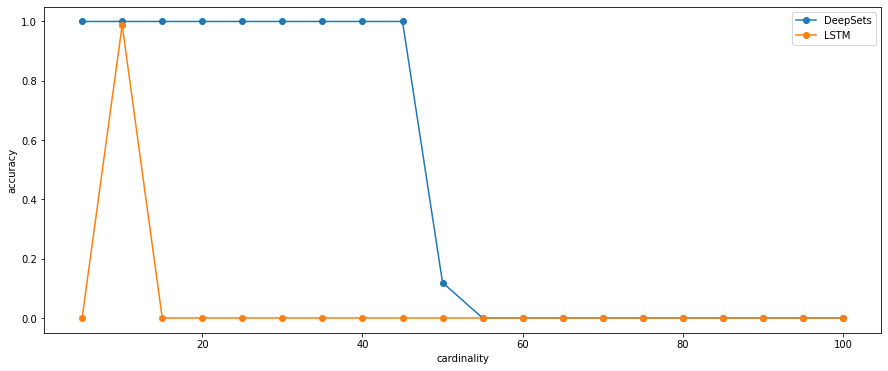

In [89]:
############## Task 7
plt.figure(figsize=(15,6))
plt.plot(cards, results['deepsets']['acc'], '-o', label='DeepSets')
plt.plot(cards, results['lstm']['acc'], '-o', label='LSTM')
plt.xlabel('cardinality')
plt.ylabel('accuracy')
plt.legend()
plt.show()

#Part 2 - Learning with Proteins

##Utils

In [61]:
def load_data(): 
    """
    Function that loads graphs
    """  
    graph_indicator = np.loadtxt("/content/drive/MyDrive/Cours_MVA/ALTEGRAD/Lab_7_Learning_on_Sets_Learning_with_Proteins/code/data/graph_indicator.txt", dtype=np.int64)
    _,graph_size = np.unique(graph_indicator, return_counts=True)
    
    edges = np.loadtxt("/content/drive/MyDrive/Cours_MVA/ALTEGRAD/Lab_7_Learning_on_Sets_Learning_with_Proteins/code/data/edgelist.txt", dtype=np.int64, delimiter=",")
    A = sp.csr_matrix((np.ones(edges.shape[0]), (edges[:,0], edges[:,1])), shape=(graph_indicator.size, graph_indicator.size))
    A += A.T
    
    x = np.loadtxt("/content/drive/MyDrive/Cours_MVA/ALTEGRAD/Lab_7_Learning_on_Sets_Learning_with_Proteins/code/data/node_attributes.txt", delimiter=",")
    edge_attr = np.loadtxt("/content/drive/MyDrive/Cours_MVA/ALTEGRAD/Lab_7_Learning_on_Sets_Learning_with_Proteins/code/data/edge_attributes.txt", delimiter=",")
    graph_labels = np.loadtxt("/content/drive/MyDrive/Cours_MVA/ALTEGRAD/Lab_7_Learning_on_Sets_Learning_with_Proteins/code/data/graph_labels.txt", dtype=np.int64)
    
    adj = []
    features = []
    edge_features = []
    idx_n = 0
    idx_m = 0
    for i in range(graph_size.size):
        adj.append(A[idx_n:idx_n+graph_size[i],idx_n:idx_n+graph_size[i]])
        edge_features.append(edge_attr[idx_m:idx_m+adj[i].nnz,:])
        features.append(x[idx_n:idx_n+graph_size[i],:])
        idx_n += graph_size[i]
        idx_m += adj[i].nnz

    return adj, features, edge_features, graph_labels

def normalize_adjacency(A):
    """
    Function that normalizes an adjacency matrix
    """
    n = A.shape[0]
    A = A + sp.identity(n)
    degs = A.dot(np.ones(n))
    inv_degs = np.power(degs, -1)
    D = sp.diags(inv_degs)
    A_normalized = D.dot(A)

    return A_normalized

def sparse_mx_to_torch_sparse_tensor(sparse_mx):
    """
    Function that converts a Scipy sparse matrix to a sparse Torch tensor
    """
    sparse_mx = sparse_mx.tocoo().astype(np.float32)
    indices = torch.from_numpy(np.vstack((sparse_mx.row, sparse_mx.col)).astype(np.int64))
    values = torch.from_numpy(sparse_mx.data)
    shape = torch.Size(sparse_mx.shape)
    return torch.sparse.FloatTensor(indices, values, shape)

##2.1 Protein Graph Model

In [62]:
# Configuration object for graph construction
config = ProteinGraphConfig(**{"node_metadata_functions": [amino_acid_one_hot, 
                                                           expasy_protein_scale,
                                                           meiler_embedding],
                               "edge_construction_functions": [add_peptide_bonds,
                                                  add_aromatic_interactions,
                                                  add_hydrogen_bond_interactions,
                                                  add_disulfide_interactions,
                                                  add_ionic_interactions,
                                                  add_aromatic_sulphur_interactions,
                                                  add_cation_pi_interactions,
                                                  partial(add_distance_threshold, long_interaction_threshold=5, threshold=10.),
                                                  partial(add_k_nn_edges, k=3, long_interaction_threshold=2)],
                               })

PDB_CODE = "Q5VSL9"

############## Task 8
structure = download_alphafold_structure(PDB_CODE, aligned_score=False)
G = construct_graph(config=config, pdb_path=structure)

# Print number of nodes and number of edges
print('Number of nodes:', G.number_of_nodes())
print('Number of edges:', G.number_of_edges())

Output()

/usr/local/lib/python3.8/dist-packages/biopandas/pdb/pandas_pdb.py:681: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: 
https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

Number of nodes: 837
Number of edges: 4258


In [63]:
############## Task 9
#Compute the mean, median, maximum and minimum degree of the nodes of the graph. 
degrees = [G.degree[node] for node in G.nodes]

mean_degree = sum(degrees) / len(degrees)
print("mean_degree = ", mean_degree)

median_degree = statistics.median(degrees)
print("median_degree = ", median_degree)

max_degree = max(degrees)
print("max_degree = ",max_degree)

min_degree = min(degrees)
print("min_degree = ", min_degree)

mean_degree =  10.174432497013143
median_degree =  10
max_degree =  25
min_degree =  2


In [66]:
#plot the distribution of node degrees by residue type 
plot_degree_by_residue_type(G)

In [65]:
#Plot the distribution of edge types in the graph
plot_edge_type_distribution(G, title = "Distribution of edge types in the graph")

In [67]:
#Plot the residue composition of the graph 
plot_residue_composition(G)

<Axes3D: >

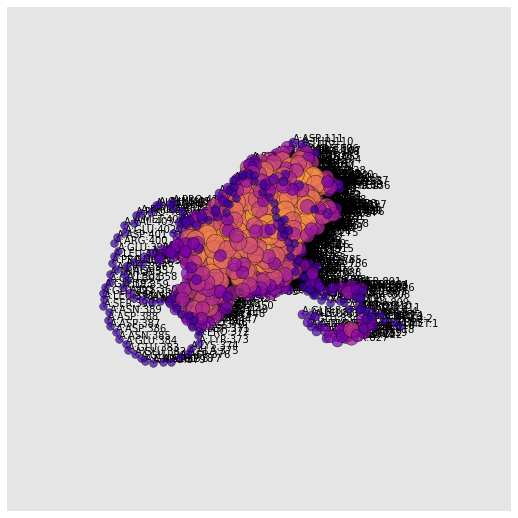

In [68]:
#Plot the protein structure graph 
plot_protein_structure_graph(G)

##2.2 Antibiotic Resistance Classification

In [70]:
class GNN(nn.Module):
    """
    Simple message passing model that consists of 2 message passing layers
    and the sum aggregation function
    """
    def __init__(self, input_dim, hidden_dim, dropout, n_class):
        super(GNN, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, hidden_dim)
        self.fc3 = nn.Linear(hidden_dim, hidden_dim)
        self.fc4 = nn.Linear(hidden_dim, n_class)
        self.bn = nn.BatchNorm1d(hidden_dim)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(dropout)

    def forward(self, x_in, adj, idx):
        ############## Task 10
        A = torch.eye(adj.size(0)) + adj
        x = self.relu(self.fc1(torch.mm(A, x_in))) 
        x = self.dropout(x)
        x = self.fc2(torch.mm(A, x))
        # sum aggregator
        idx = idx.unsqueeze(1).repeat(1, x.size(1))
        out = torch.zeros(torch.max(idx)+1, x.size(1)).to(x_in.device)
        out = out.scatter_add_(0, idx, x)
        ##################
        x = self.bn(out)
        x = self.relu(self.fc3(x))
        x = self.dropout(x)
        out = self.fc4(x)
        return F.log_softmax(out, dim=1)


##arg_classification.py

In [71]:
# Load graphs
adj, features, edge_features, y = load_data() 

# Normalize adjacency matrices
adj = [normalize_adjacency(A) for A in adj]

# Split data into training and test sets
adj_train, adj_test, features_train, features_test, y_train, y_test = train_test_split(adj, features, y, test_size=0.1)

# Initialize device
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

# Hyperparameters
epochs = 50
batch_size = 64
n_hidden = 64
n_input = 23
dropout = 0.2
learning_rate = 0.001
n_class = 2

# Compute number of training and test samples
N_train = len(adj_train)
N_test = len(adj_test)

# Initializes model and optimizer
model = GNN(n_input, n_hidden, dropout, n_class).to(device)
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
loss_function = nn.CrossEntropyLoss()

# Train model
for epoch in range(epochs):
    t = time.time()
    model.train()
    train_loss = 0
    correct = 0
    count = 0
    # Iterate over the batches
    for i in range(0, N_train, batch_size):
        adj_batch = list()
        features_batch = list()
        idx_batch = list()
        y_batch = list()
        
        # Create tensors
        for j in range(i, min(N_train, i+batch_size)):
            n = adj_train[j].shape[0]
            adj_batch.append(adj_train[j]+sp.identity(n))
            features_batch.append(features_train[j])
            idx_batch.extend([j-i]*n)
            y_batch.append(y_train[j])
            
        adj_batch = sp.block_diag(adj_batch)
        features_batch = np.vstack(features_batch)

        adj_batch = sparse_mx_to_torch_sparse_tensor(adj_batch).to(device)
        features_batch = torch.FloatTensor(features_batch).to(device)
        idx_batch = torch.LongTensor(idx_batch).to(device)
        y_batch = torch.LongTensor(y_batch).to(device)
        
        optimizer.zero_grad()
        output = model(features_batch, adj_batch, idx_batch)
        loss = loss_function(output, y_batch)
        train_loss += loss.item() * output.size(0)
        count += output.size(0)
        preds = output.max(1)[1].type_as(y_batch)
        correct += torch.sum(preds.eq(y_batch).double())
        loss.backward()
        optimizer.step()
    
    if epoch % 5 == 0:
        print('Epoch: {:03d}'.format(epoch+1),
              'loss_train: {:.4f}'.format(train_loss / count),
              'acc_train: {:.4f}'.format(correct / count),
              'time: {:.4f}s'.format(time.time() - t))
        
# Evaluate model
model.eval()
test_loss = 0
correct = 0
count = 0
# Iterate over the batches
for i in range(0, N_test, batch_size):
    adj_batch = list()
    features_batch = list()
    idx_batch = list()
    y_batch = list()
    
    # Create tensors
    for j in range(i, min(N_test, i+batch_size)):
        n = adj_test[j].shape[0]
        adj_batch.append(adj_test[j]+sp.identity(n))
        features_batch.append(features_test[j])
        idx_batch.extend([j-i]*n)
        y_batch.append(y_test[j])
        
    adj_batch = sp.block_diag(adj_batch)
    features_batch = np.vstack(features_batch)

    adj_batch = sparse_mx_to_torch_sparse_tensor(adj_batch).to(device)
    features_batch = torch.FloatTensor(features_batch).to(device)
    idx_batch = torch.LongTensor(idx_batch).to(device)
    y_batch = torch.LongTensor(y_batch).to(device)

    output = model(features_batch, adj_batch, idx_batch)
    loss = loss_function(output, y_batch)
    test_loss += loss.item() * output.size(0)
    count += output.size(0)
    preds = output.max(1)[1].type_as(y_batch)
    correct += torch.sum(preds.eq(y_batch).double())

print('loss_test: {:.4f}'.format(test_loss / count),
      'acc_test: {:.4f}'.format(correct / count),
      'time: {:.4f}s'.format(time.time() - t))

Epoch: 001 loss_train: 0.6388 acc_train: 0.6594 time: 186.9878s
Epoch: 006 loss_train: 0.5498 acc_train: 0.7338 time: 185.3777s
Epoch: 011 loss_train: 0.5337 acc_train: 0.7397 time: 186.6733s
Epoch: 016 loss_train: 0.5219 acc_train: 0.7456 time: 188.5169s
Epoch: 021 loss_train: 0.5130 acc_train: 0.7460 time: 187.3224s
Epoch: 026 loss_train: 0.4996 acc_train: 0.7564 time: 186.1703s
Epoch: 031 loss_train: 0.4906 acc_train: 0.7623 time: 187.6676s
Epoch: 036 loss_train: 0.4800 acc_train: 0.7623 time: 185.6593s
Epoch: 041 loss_train: 0.4669 acc_train: 0.7697 time: 186.2311s
Epoch: 046 loss_train: 0.4634 acc_train: 0.7753 time: 186.0788s
loss_test: 0.4392 acc_test: 0.7807 time: 203.8801s
